# Zadanie 2.2 – Podstawowe ograniczenia w TopFarm2

W tej lekcji uczymy się:
- jak definiować **obszar dozwolony** dla turbin (boundary constraint)
- jak wymuszać **minimalną odległość** między turbinami (spacing constraint)
- czym są: design variables, constraints, driver, problem

Wykonaliśmy kilka wizualizacji, żeby zobaczyć, jak różne ograniczenia wpływają na możliwe układy turbin.

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# TopFarm2 – najważniejsze komponenty
from topfarm import TopFarmProblem
from topfarm.plotting import XYPlotComp
from topfarm.constraint_components.boundary import XYBoundaryConstraint, CircleBoundaryConstraint
from topfarm.constraint_components.spacing import SpacingConstraint
from topfarm.cost_models.cost_model_wrappers import CostModelComponent

print("Imports OK")

Imports OK


**Imports OK**  
Wszystkie potrzebne moduły zaimportowały się bez błędów.  
W praktyce oznacza to, że mamy dostęp do narzędzi TopFarm2 do definiowania granic obszaru i odległości między turbinami.

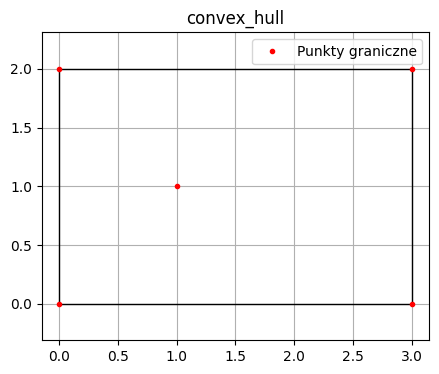

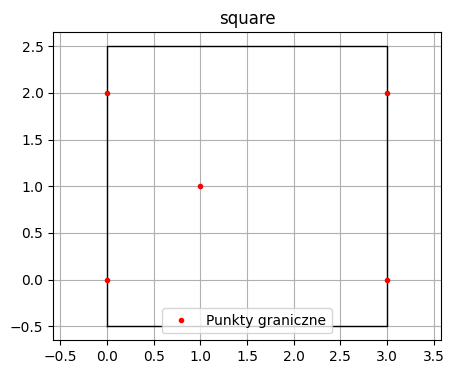

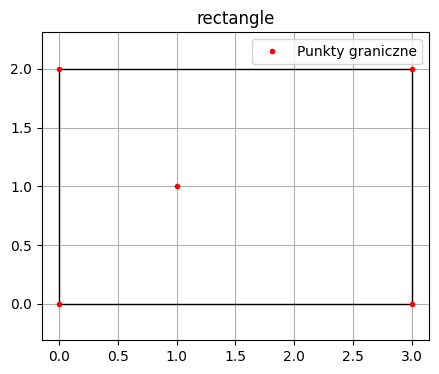

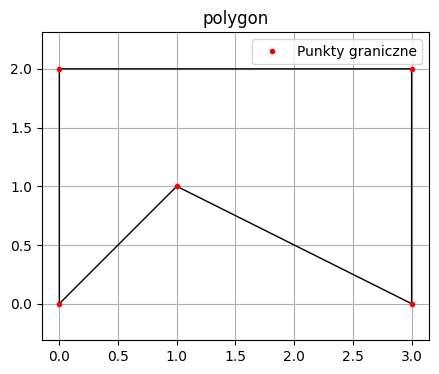

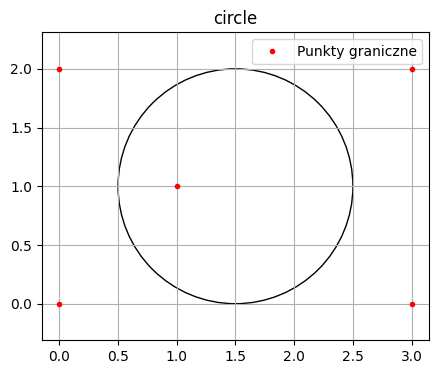

In [3]:
# Punkty opisujące przykładowy obszar
boundary = np.array([
    (0, 0),
    (1, 1),
    (3, 0),
    (3, 2),
    (0, 2)
])

# Dwie "sztuczne" turbiny – tylko do pokazania wizualizacji
x = [0.5, 1.5]
y = [0.5, 1.5]

# Bardzo prosty koszt – nie optymalizujemy, tylko rysujemy
dummy_cost = CostModelComponent(
    input_keys=[],
    n_wt=2,
    cost_function=lambda: 1.0
)


def plot_boundary(title, constraint):
    tf = TopFarmProblem(
        design_vars={'x': x, 'y': y},
        cost_comp=dummy_cost,
        constraints=[constraint],
        plot_comp=XYPlotComp()
    )
    
    plt.figure(figsize=(5, 4))
    plt.title(title)
    tf.plot_comp.plot_constraints()
    plt.plot(boundary[:, 0], boundary[:, 1], 'r.', label='Punkty graniczne')
    plt.axis('equal')
    plt.grid(True)
    plt.legend()
    plt.show()


# Pokazujemy różne interpretacje tej samej granicy
plot_boundary('convex_hull', XYBoundaryConstraint(boundary, 'convex_hull'))
plot_boundary('square',      XYBoundaryConstraint(boundary, 'square'))
plot_boundary('rectangle',   XYBoundaryConstraint(boundary, 'rectangle'))
plot_boundary('polygon',     XYBoundaryConstraint(boundary, 'polygon'))
plot_boundary('circle',      CircleBoundaryConstraint((1.5, 1.0), 1.0))

**Różne typy granic (boundary)**

Narysowaliśmy tę samą grupę punktów na pięć sposobów:

- **convex_hull** – otoczka wypukła (najczęściej używana w praktyce)
- **square** – prostokąt otaczający (osiowy)
- **rectangle** – prostokąt dopasowany do osi
- **polygon** – dokładny wielokąt przez podane punkty
- **circle** – okrąg o środku i promieniu

W projektowaniu farm wiatrowych najczęściej używa się **convex_hull** lub **polygon**.

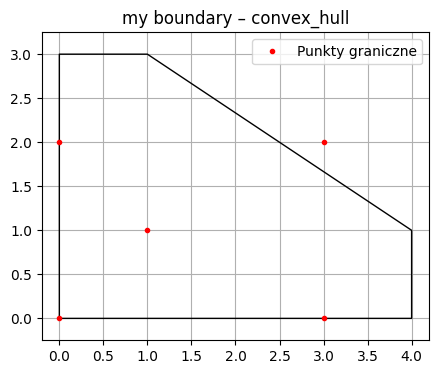

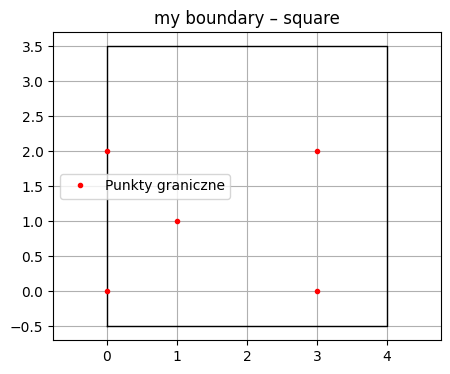

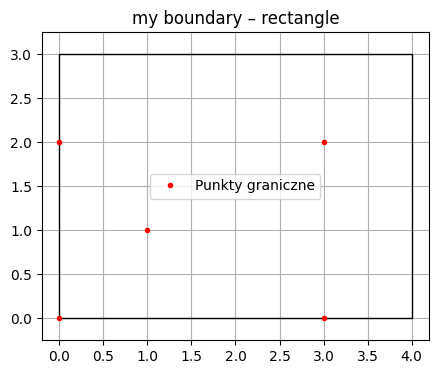

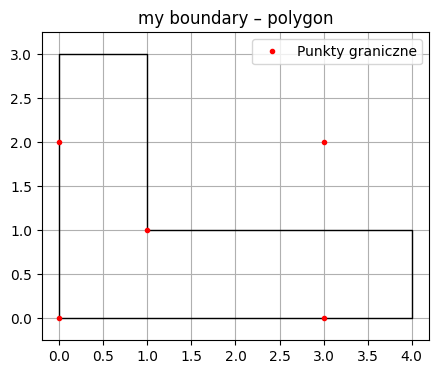

In [4]:
# Nasza własna granica – np. kształt litery L lub zygzak
my_boundary = np.array([
    (0, 0),
    (4, 0),
    (4, 1),
    (1, 1),
    (1, 3),
    (0, 3)
])

for btype in ['convex_hull', 'square', 'rectangle', 'polygon']:
    plot_boundary(f'my boundary – {btype}', XYBoundaryConstraint(my_boundary, btype))

**Własna zaprojektowana granica**

Zaprojektowaliśmy obszar przypominający literę L.  
Widać wyraźnie, że:

- **convex_hull** wygładza kształt i daje największy możliwy obszar
- **polygon** trzyma się dokładnie naszych punktów
- **square** i **rectangle** dają dużo mniejsze, prostokątne obszary

W rzeczywistości convex_hull jest najczęściej praktyczny.

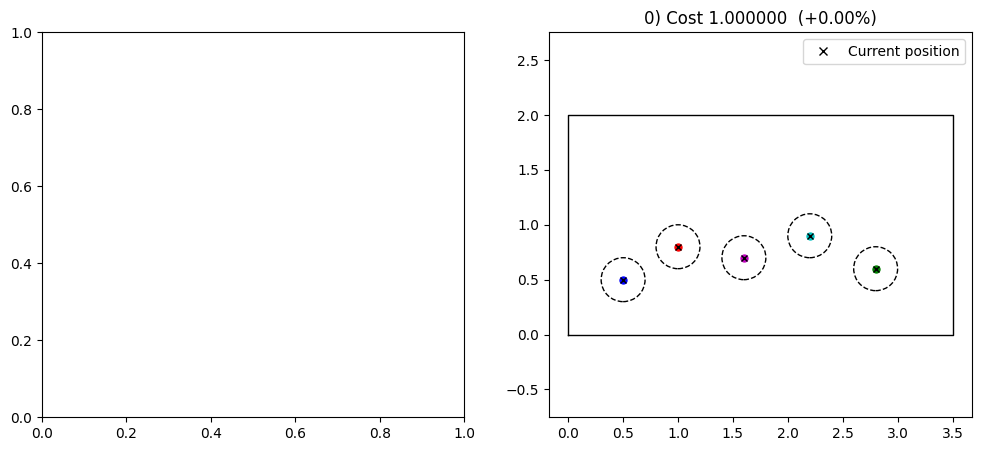

TypeError: XYPlotComp.plot_constraints() got an unexpected keyword argument 'ax'

In [5]:
# 5 turbin – celowo dość blisko siebie
x5 = np.array([0.5, 1.0, 1.6, 2.2, 2.8])
y5 = np.array([0.5, 0.8, 0.7, 0.9, 0.6])

big_boundary = np.array([(0,0), (3.5,0), (3.5,2), (0,2)])

dummy_cost5 = CostModelComponent([], 5, lambda: 1.0)

# -----------------------
# Dwa przypadki do porównania
# -----------------------

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

for ax, spacing in zip(axes, [0.4, 1.0]):
    tf = TopFarmProblem(
        design_vars={'x': x5, 'y': y5},
        cost_comp=dummy_cost5,
        constraints=[
            XYBoundaryConstraint(big_boundary, 'polygon'),
            SpacingConstraint(spacing)
        ],
        plot_comp=XYPlotComp()
    )
    
    tf.setup()
    tf.evaluate()
    
    ax.set_title(f"Spacing = {spacing}")
    tf.plot_comp.plot_constraints(ax=ax)
    ax.plot(big_boundary[:,0], big_boundary[:,1], '-k', label='Granica')
    ax.scatter(x5, y5, s=80)
    
    for i, (xx, yy) in enumerate(zip(x5, y5), 1):
        ax.text(xx+0.05, yy+0.05, f"T{i}", fontsize=12)
    
    ax.axis('equal')
    ax.grid(True)
    ax.legend()

plt.tight_layout()
plt.show()

**SpacingConstraint – minimalna odległość między turbinami**

Porównaliśmy dwa przypadki:

- **spacing = 0.4** → większość turbin jest za blisko → czerwone obszary naruszeń
- **spacing = 1.0** → turbiny są rozstawione dalej → brak naruszeń

W rzeczywistych projektach minimalna odległość to zazwyczaj **3–7 × średnica wirnika** (w zależności od producenta i warunków wiatrowych).

### Co zmienialiśmy i jaki był efekt

| Co zrobiliśmy                             | Efekt na wykresie / zrozumienie projektu                     |
|-------------------------------------------|----------------------------------------------------------------|
| Narysowaliśmy 5 typów boundary            | Zobaczyliśmy, jak różne algorytmy interpretują te same punkty |
| Zaprojektowaliśmy własną granicę (kształt L) | convex_hull daje największy użyteczny obszar                   |
| Porównaliśmy spacing 0.4 vs 1.0           | Przy małej odległości widać naruszenia (czerwone obszary)     |
| Użyliśmy subplotów do porównania          | Łatwiej zobaczyć różnicę w jednym spojrzeniu                   |
| Dodaliśmy etykiety T1–T5                  | Lepiej widać, która turbina jest gdzie                         |

Najważniejszy wniosek: **ograniczenia boundary i spacing bardzo mocno decydują o tym, jaki układ turbin jest w ogóle możliwy**.